Index-Building:
The factors used include the following:
- planet mass (Mjup)
- planet radius (Rjup)
- planet temperature (K)
- planet density CALCULATE
- radiation intensity (W/m^2) CALCULATE
- star distance (pc)
- AND/OR HZ measurement CALCULATE
- star metallicity ?? fraction
- star mass (Msun)
- sun radius (Rsun)
- star age ?? Gy
- star effective temperature (K)
- interactions?

The index will consist of the following:
- planet mass +
planet radius +
planet temperature +
star distance (HZ) + 
radiation intensity

Weighing can be determined in 1 of 2 ways:
- use a correlation regression as done in Cobb Douglas
- use difference from "ideal" Earth on a normal distribution to determine the importance of outliers
- tweaking post-factum to ensure earth is No.1

1. Import data and packages

In [1]:
# import packages
import numpy as np
import pandas as pd
import math 
from math import pi
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None) 


# import data
data = pd.read_csv('../Data/exo_data.csv')

#display data
# print(data)

2. Calculate density

2.1 Convert: 
- M(jup) to M(earth)
- R(jup) to R(earth)

In [2]:
# M(jup) to M(earth)
def mjup_to_mearth(planet_mass_mjup):
    mass_mearth = planet_mass_mjup * 317.8 

    return mass_mearth

data['planet_mass_mearth'] = data.apply(lambda row: mjup_to_mearth(row['planet_mass_mjup']), axis = 1)



# R(jup) to R(earth)
def rjup_to_rearth(planet_radius_rjup):
    radius_rearth = planet_radius_rjup * 11.2

    return radius_rearth

data['planet_radius_rearth'] = data.apply(lambda row: rjup_to_rearth(row['planet_radius_rjup']), axis = 1)

# print(data)

2.2 Calculate volume 

In [3]:
# 4/3 * pi* r^3
def volume_formula(planet_radius_rearth):
    volume = (4/3) * np.pi * (planet_radius_rearth ** 3)

    return volume

data['planet_volume_rearth'] = data.apply(lambda row: volume_formula(row['planet_radius_rearth']), axis = 1)

# print(data)

In [4]:
# print(data)

3. Calculate Habitability Zone boundaries

3.2 Version 2: More complex

In [5]:
# Function to convert mass to luminosity 
def mass_to_luminosity(star_mass_msun):
    return star_mass_msun  ** 3.6

# Function to calculate habitable zone boundaries 
def calculate_habitable_zone(Luminosity_Lsun):
    inner_boundary = np.sqrt(Luminosity_Lsun / 1.1)
    outer_boundary = np.sqrt(Luminosity_Lsun / 0.53)
    return inner_boundary, outer_boundary 

# Convert mass to luminosity 
data['Luminosity_Lsun'] = data['star_mass_msun'].apply(mass_to_luminosity) 



# inner flux 
def s_inner(Teff):
    s_inner = 1.296 - (2.139e-4 * Teff) + 4.19e-8 * (Teff**2)

    return s_inner

data['Flux_inner_HZ'] = data['star_teff_K'].apply(s_inner) 

# outer flux
def s_outer(Teff):
    s_outer = 0.234 - (1.319e-5 * Teff) + 6.19e-10 * (Teff**2)

    return s_outer

data['Flux_outer_HZ'] = data['star_teff_K'].apply(s_outer) 

# inner boundary
def r_inner(Luminosity_Lsun, Flux_inner_HZ):
    r_inner = np.sqrt(Luminosity_Lsun / Flux_inner_HZ)

    return r_inner

data['HZ_inner_AU'] = data.apply(lambda row: r_inner(row['Luminosity_Lsun'], row['Flux_inner_HZ']), axis = 1)


# outer boundary
def r_outer(Luminosity_Lsun, Flux_outer_HZ):
    r_outer = np.sqrt(Luminosity_Lsun / Flux_outer_HZ)

    return r_outer * 0.85

data['HZ_outer_AU'] = data.apply(lambda row: r_outer(row['Luminosity_Lsun'], row['Flux_outer_HZ']), axis = 1)

# print(data)

In [6]:
# print(data)

4. Calculate middle of HZ

In [7]:
def HZ_middle_ideal(HZ_inner, HZ_outer):
    HZ_middle = (HZ_inner + HZ_outer) / 2

    return HZ_middle

# data['HZ_middle_AU_s'] = data.apply(lambda row: HZ_middle_ideal(row['HZ_inner_AU_s'], row['HZ_outer_AU_s']), axis = 1)
data['HZ_middle_ideal_AU'] = data.apply(lambda row: HZ_middle_ideal(row['HZ_inner_AU'], row['HZ_outer_AU']), axis = 1)


5. Radiation Intensity
- Calculate distance from planet to star in m

In [8]:
def pc_to_m(star_distance_pc):
    star_distance_m = star_distance_pc * 3.086e+16

    return star_distance_m

data['star_distance_m'] = data['star_distance_pc'].apply(pc_to_m) 


In [9]:
# radiation = L / 4pi(r)^2 W/m^2
def radiation_I(luminosity, distance_m):
    radiation_I = luminosity / (4*np.pi*((distance_m)**2))

    return radiation_I

data['radiation_I'] = data.apply(lambda row: radiation_I(row['Luminosity_Lsun'], row['star_distance_m']), axis = 1)

In [10]:
# print(data)

5. Calculate pre-main sequence time and main-sequence lifetime for given stars. ideal = middle main sequence, non-ideal = pre or post-main sequence

5.1 Calculate pre-main sequence phase (tPMS)

In [11]:
def pre_seq_GY(star_mass_msun):
    pre_seq_length = ( 10e7*(star_mass_msun**-2.5) ) / 10e9

    return pre_seq_length

data['pre_seq_GY'] = data['star_mass_msun'].apply(pre_seq_GY) 
# print(data)

5.2 Calculate main-sequence lifetime (tMS)

In [12]:
def main_seq_GY(star_mass_msun):
    main_seq_length = 10*(1/(star_mass_msun**2.5))

    return main_seq_length

data['main_seq_GY'] = data['star_mass_msun'].apply(main_seq_GY) 

# print(data)

5.3 Calculate end of main sequence phase (transition into post-main sequence)

In [13]:
data['main_seq_end_GY'] = data['pre_seq_GY'] + data['main_seq_GY']

# print(data)

5.4 Calculate mid-main sequence time

In [14]:
def mid_main_seq_GY(main_seq_end_GY, pre_seq_GY):
    mid_main_seq = (main_seq_end_GY - pre_seq_GY) / 2

    return mid_main_seq

data['mid_main_seq_GY'] = data.apply(lambda row: mid_main_seq_GY(row['main_seq_end_GY'], row['pre_seq_GY']), axis = 1)
# print(data)

In [15]:
# print(data)

6. Calculate water potential !!!!

In [16]:
def pc_to_AU(star_distance_pc):
    star_distance_AU = star_distance_pc  * 206265

    return star_distance_AU

data['star_distance_AU'] = data['star_distance_pc'].apply(pc_to_AU) 
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [17]:
import math

def stability_analysis(temperature, mid_ideal, min_nonideal, max_nonideal, LB, UB, extrema = 0.1):

    def map_value(value, from_min, from_max, to_min, to_max):
        """
        Maps a value from one range to another.

        Parameters:
        value (float): The value to be mapped.
        from_min (float): The minimum of the original range.
        from_max (float): The maximum of the original range.
        to_min (float): The minimum of the target range.
        to_max (float): The maximum of the target range.

        Returns:
        float: The value mapped to the target range.
        """
        # Calculate the proportion of the value within the original range
        proportion = (value - from_min) / (from_max - from_min)
        
        # Calculate the mapped value in the target range
        mapped_value = to_min + proportion * (to_max - to_min)
        
        return mapped_value

    # Calculate shifted max
    '''
    mid_ideal = 350
    min_nonideal = 200
    max_nonideal = 500 
    '''

    # Case 0: temperature is ideal -> return 1
    if temperature == mid_ideal:
        return 1
    
    # Case 1: temperature is between ideal and max nonideal -> map temperature value from -1 to -0.1
    if mid_ideal < temperature < max_nonideal:
        index = 0 - map_value(temperature, mid_ideal, max_nonideal, -1, -extrema)
        return index
    
    # Case 2: temperature is between min nonideal and ideal -> map temperature value from 0.1 to 1
    if min_nonideal < temperature < mid_ideal:
        index = map_value(temperature, min_nonideal, mid_ideal, extrema, 1)
        return index
    
    # Case 3: temperature is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < temperature < UB:
        decrement = map_value(temperature, max_nonideal, UB, 0, extrema)
        index = 0.25 - decrement
        return index
    
    # Case 4: temperature is between LB and min nonideal -> by definition the temperature is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < temperature < min_nonideal:
        decrement = map_value(temperature, LB, min_nonideal, -extrema, 0)
        index = 0.25 + decrement
        return index

# Constants
k_gravity = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-1
k_Boltzman = 1.380649e-23  # Boltzmann constant, J K^-1
AU = 1.496e11  # Astronomical unit in meters
molecular_mass=4.65e-26 # N2
earth_mass=5.972e24
earth_radius=6.371e6
L_sun = 3.828e26 

# Functions to calculate necessary parameters
"""
Calculate the surface gravity of the planet.
mass: Mass of the planet in kg == Mearth?
radius: Radius of the planet in meters == Rearth
"""
def calculate_surface_gravity(mass, radius):
    grav = k_gravity * (mass*earth_mass) / (radius*earth_radius)**2
    grav_earth = grav / 9.81
    return grav



"""
Calculate the escape velocity of the planet.
mass: Mass of the planet in kg
radius: Radius of the planet in meters
"""
def calculate_escape_velocity(mass, radius):
   
    return math.sqrt(2 * k_gravity * (mass*earth_mass) / (radius*earth_radius))





"""
Calculate the thermal velocity of atmospheric molecules.
temperature: Surface temperature in Kelvin
molecular_mass: Mass of the gas molecule in kg (for N2, approximately 4.65e-26 kg)
"""
def calculate_thermal_velocity(temperature, molecular_mass):
    return math.sqrt(3 * k_Boltzman * temperature / molecular_mass)





"""
Determine if the planet is within the habitable zone of its star.
distance: Distance from the star in AU
luminosity: Luminosity of the star in watts
"""
def is_in_habitable_zone(distance, luminosity, temperature):
    inner_boundary = math.sqrt((luminosity) / (1.296 - (2.139e-4 * temperature) + 4.19e-8 * (temperature**2)))
    outer_boundary = math.sqrt((luminosity) / ( 0.234 - (1.319e-5 * temperature) + 6.19e-10 * (temperature**2)))
    return inner_boundary <= distance <= outer_boundary


"""
Evaluate the probability of the planet being able to sustain liquid water.
mass: Mass of the planet in kg
radius: Radius of the planet in meters
distance: Distance from the star in AU
temperature: Surface temperature in Kelvin
luminosity: Luminosity of the star in watts (default is Sun-like)
molecular_mass: Mass of the atmospheric gas molecule in kg (default is for nitrogen, N2)
"""
def evaluate_water_sustenance(mass, radius, distance, temperature, luminosity, molecular_mass= 4.65e-26):
    gravity = calculate_surface_gravity(mass, radius)
    escape_velocity = calculate_escape_velocity(mass, radius)
    thermal_velocity = calculate_thermal_velocity(temperature, molecular_mass)
    in_habitable_zone = is_in_habitable_zone(distance, luminosity, temperature)
    
    # Surface gravity assessment (reasonable range 0.38g to 2g where g is Earth's gravity)
    #gravity_assessment = (0.38 * 9.81) <= gravity <= (2 * 9.81)
    gravity_contribution = stability_analysis(gravity, 9.81, 0.38 * 9.81, 2 * 9.81, 0.0 * 9.81, 30 * 9.81)

    
    # Atmospheric retention assessment (escape velocity should be much higher than thermal velocity)
    atmospheric_retention = 0 if thermal_velocity == 0 else escape_velocity > 10 * thermal_velocity
    
    # Surface temperature assessment (within 0°C to 100°C for liquid water)
    #temperature_assessment = 273 <= temperature <= 373
    temperature_contribution = stability_analysis(temperature, 300, 250, 400, 0, 5000, 0.1)
    
    # Combine assessments into a probability category
    """
    if in_habitable_zone and temperature_assessment and atmospheric_retention and gravity_assessment:
        return 0.75
    elif in_habitable_zone and (temperature_assessment or atmospheric_retention or gravity_assessment):
        return 0.5
    else:
        return 0.25
    """
    index = (in_habitable_zone + temperature_contribution + atmospheric_retention + gravity_contribution) * 0.25
    return index

# Example use case:
# data['mid_main_seq_GY'] = data.apply(lambda row: mid_main_seq_GY(row['main_seq_end_GY'], row['pre_seq_GY']), axis = 1)


data["water"] = data.apply(lambda row: evaluate_water_sustenance(row['planet_mass_mearth'], row['planet_radius_rearth'], row['star_distance_AU'], row['temp_calculated_K'],row['Luminosity_Lsun']), axis = 1)
    #evaluate_water_sustenance(planet_mass, planet_radius, distance_from_star, surface_temperature)
print(data)


          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6. Calculate ideal and non-ideal values ??

- planet mass M(earth) == Earth? between 0.5 and 5 earth masses as can maintain atmosphere and possibly have H2O (aq)
- planet radius R(earth) == Earth? between 0.8 and 1.5 earth radii as above might have thick gas envelopes and be more like mini-neptures/gas giant
- planet temperature (K) == Earth? between 0 and 100'c where water can remain liquid as standard pressure
- planet density == Earth? between 5 and 5.5 g/cm3
- radiation intensity (W/m^2) == Earth ? limits at HZ?
- HZ measurement == normal distribution, y = middle of HZ; non ideal = | 2sigma | where 1.5 sigma == boundary 
- star age ?? Gy maybe calculate lifetime based on Tms = 10gy * (1/(Mstar^2.5))  where Tms is main sequence lifetime. Pre-main sequence phase tpms = 10^7 * M^-2.5
- interactions??

In [18]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.1 Mass, radius etc ideal and non-ideal values -> in water index?

6.3 Temperature ideal and non-ideal values

In [19]:
# calculate temperature in C

def K_to_C(temp_calculated_K):

    temp_calculated_C = temp_calculated_K - 273

    return temp_calculated_C
data['temp_calculated_C'] = data['temp_calculated_K'].apply(K_to_C) 


## ideal = 20 X
## non ideal: 0 and 100

In [20]:
# we need a buffer....
# i timesed them by 2. check relevance

In [21]:
def map_temperature(value, V_ideal=15, V_min=-20*2, V_max=100*2, d=1):
   
    # Calculate distances from ideal to min and max
    distance_min = V_ideal - V_min
    distance_max = V_max - V_ideal
    
    # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if value <= V_ideal:
        # Map values between V_min and V_ideal to [0, d]
        new_value = d * (V_ideal - value) / distance_min
    else:
        # Map values between V_ideal and V_max to [0, d]
        new_value = d * (value - V_ideal) / distance_max
    
    new_value = new_value if new_value <=1 else 1
    remapped_value = d/2 + (d/2 - new_value)

    return remapped_value if remapped_value > 0 else remapped_value + 0.000001



data['map_temperature'] = data['temp_calculated_C'].apply(map_temperature) 
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.4 Radiation intensity
!!!!!!!!! this needs work

In [22]:
# ideal = intensity at LB
# non-ideal = intensity at sun

# print(data)

In [23]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [24]:
# radiation = L / 4pi(r)^2 W/m^2
# 1**2 means 1m away from the sun
# 1 AU = 1.496e+11 m

data['HZ_inner_m'] = data['HZ_inner_AU'] * 1.496e+11
data['HZ_outer_m'] = data['HZ_outer_AU'] * 1.496e+11

def radiation_I_max(luminosity, distance_m):
    middle = (1 + distance_m)/2
    radiation_max_I = luminosity / (4*np.pi*((middle)**2))
    return radiation_max_I
data['radiation_max'] = data.apply(lambda row: radiation_I_max(row['Luminosity_Lsun'], row['HZ_inner_AU']), axis = 1)

def radiation_I_ideal(luminosity, distance_m):
    radiation_ideal_I = luminosity / (4*np.pi*((distance_m)**2))

    return radiation_ideal_I
data['radiation_min'] = data.apply(lambda row: radiation_I_ideal(row['Luminosity_Lsun'], row['HZ_outer_AU']), axis = 1)

print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [25]:
def map_radiation(planet_radiation, ideal_radiation, worst_radiation, result_non_ideal=0.25, result_ideal=1):
   
    # Calculate distances from ideal to min and max
    result_inverse = (planet_radiation - ideal_radiation) / (worst_radiation - ideal_radiation) * (result_ideal-result_non_ideal) + result_non_ideal
    
    # Apply result boundaries
    if result_inverse < result_non_ideal: result_inverse = result_non_ideal
    if result_inverse > result_ideal: result_inverse = result_ideal

    rad_check = planet_radiation > ideal_radiation

    # new_value = new_value if new_value <=1 else 1
    result = (result_ideal + result_non_ideal) - result_inverse

    return result



data['map_radiation'] = data.apply(lambda row: map_radiation(row['radiation_I'], row['radiation_min'], row['radiation_max']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [26]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.5 HZ normal distribution; ideal and non-ideal values !!! needs work

In [27]:
# Math is right, HZ outer is to big hence mars looks better
# Potentially recalculate HZ outer
def map_HZ(value, mid_ideal, min_nonideal, max_nonideal, d=1):
    # Calculate shifted max
    d_max = max_nonideal - mid_ideal
    shifted_max = 1.5*d_max + mid_ideal

    # Calculate shifted min
    d_min = mid_ideal - min_nonideal
    shifted_min = mid_ideal - 1.5*d_min

    # Calculate distances from ideal to min and max
    distance_min = mid_ideal - shifted_min
    distance_max = shifted_max - mid_ideal
    
    # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if value <= mid_ideal:
        # Map values between V_min and V_ideal to [0, d]
        new_value = d * (mid_ideal - value) / distance_min
    else:
        # Map values between V_ideal and V_max to [0, d]
        new_value = d * (value - mid_ideal) / distance_max
    

    ## add if <0 then 0
    
    if new_value >=1:
        new_value = 1
    elif new_value <=0:
        new_value = 0
    else:
        new_value = new_value

    return d/2 + (d/2 - new_value)


"""
def map_HZ(x, lower_bound, upper_bound, threshold=1.5):

    # Calculate the mean (center of the distribution)
    mean = (upper_bound + lower_bound) / 2
    
    # Calculate the standard deviation
    std_dev = (upper_bound - lower_bound) / (2 * threshold)
    
    # Compute the normalized Gaussian function value using the simplified formula
    normalized_gaussian_value = np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    
    return normalized_gaussian_value
"""

data['map_HZ'] = data.apply(lambda row: map_HZ(row['star_distance_AU'], row['HZ_middle_ideal_AU'], row['HZ_inner_AU'], row['HZ_outer_AU']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.6 Star age ideal and non-ideal values !!! Soething fucked up and now values are weird!!!

In [28]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [29]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

AGE VERSION 2

In [30]:
# ideal = mid_main_seq_GY  
# non ideal: > main_seq_end_GY  OR < pre_seq_GY

def map_star_age(value, age_ideal, main_seq_LB, main_seq_UB, d=1): # age_max_ms_end
   
    # Calculate distances from ideal to min and max
    distance_min = age_ideal - main_seq_LB
    distance_max = main_seq_UB - age_ideal
    
    # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if value <= age_ideal >= main_seq_LB:
        new_value = d * (age_ideal - value) / distance_min

    elif value <= main_seq_LB:
        new_value = (-d) * ((age_ideal - value) / (age_ideal))
    
    elif value >= age_ideal <=main_seq_UB:
        new_value = d * (value - age_ideal) / distance_max

    else:
        new_value = (-d) * ((value - age_ideal) / (2*age_ideal))
    
    return d/2 + (d/2 - new_value)


data['map_star_age'] = data.apply(lambda row: map_star_age(row['star_age_Gy'], row['mid_main_seq_GY'], row['pre_seq_GY'], row['main_seq_end_GY']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [31]:
# data['star_distance']

7. Join together:
- water 
- - (mass , radius, temp, mol mass, distance, luminosity).
- - mass, radius => surface gravity 
- - mass, radius => escape velocity
- - temperature, mol mass (N2) => thermal velocity
- - star distance, luminosity => HZ
- - - then assess:
- - - gravity
- - - thermal velocity + escape velocity => atmospheric retention
- - - temperature


- map_temperature (temp K)


- map_radiation (luminosity, star distance) 
- - not too important


- map_HZ (luminosity, star distance)
- - luminosity => flux => boundaries

- map_star_age (age)

In [32]:
"""
def HUIndex(water, temp, radiation, HZ, star_age, weight_water = None, weight_temp = None, weight_radiation = None, weight_HZ = None, weight_star_age = None):
    weighting = [weight_water, weight_temp, weight_radiation, weight_HZ, weight_star_age]

# sum of weights
    sum_provided_weights = 0
# ask about user weighing
    if weight_water is None:
        weight_water = float(input("What is the weighing for the liquid water potential factor? "))
        sum_provided_weights += weight_water
    else:
        sum_provided_weights += weight_water
    if weight_temp is None:
        weight_temp = float(input("What is the weighing for the surface temperature factor? "))
        sum_provided_weights += weight_temp
    else:
        sum_provided_weights += weight_temp
    if weight_radiation is None:
        weight_radiation = float(input("What is the weighing for the surface radiation factor? "))
        sum_provided_weights += weight_radiation
    else:
        sum_provided_weights += weight_radiation
    if weight_HZ is None:
        weight_HZ = float(input("What is the weighing for the Habitability Zone factor? "))
        sum_provided_weights += weight_HZ
    else:
        sum_provided_weights += weight_HZ
    if weight_star_age is None:
        weight_star_age = float(input("What is the weighing for the star age factor? "))
        sum_provided_weights += weight_star_age
    else:
        sum_provided_weights += weight_star_age

    if sum_provided_weights > 1:
        print('The sum of provided weights is {sum_provided_weights}, which is greater than 1. /n Please provide new exponents  ')
    

    HUI = (water** weight_water) * (temp**weight_temp) * (radiation**weight_radiation) * (HZ ** weight_HZ) * (star_age ** weight_star_age)
    return HUI
     
    
data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)
"""

'\ndef HUIndex(water, temp, radiation, HZ, star_age, weight_water = None, weight_temp = None, weight_radiation = None, weight_HZ = None, weight_star_age = None):\n    weighting = [weight_water, weight_temp, weight_radiation, weight_HZ, weight_star_age]\n\n# sum of weights\n    sum_provided_weights = 0\n# ask about user weighing\n    if weight_water is None:\n        weight_water = float(input("What is the weighing for the liquid water potential factor? "))\n        sum_provided_weights += weight_water\n    else:\n        sum_provided_weights += weight_water\n    if weight_temp is None:\n        weight_temp = float(input("What is the weighing for the surface temperature factor? "))\n        sum_provided_weights += weight_temp\n    else:\n        sum_provided_weights += weight_temp\n    if weight_radiation is None:\n        weight_radiation = float(input("What is the weighing for the surface radiation factor? "))\n        sum_provided_weights += weight_radiation\n    else:\n        sum_p

In [33]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [34]:
"""
def HUIndex(water, temp, radiation, HZ, star_age, weight_water=None, weight_temp=None, weight_radiation=None, weight_HZ=None, weight_star_age=None):
    
    Calculate the Habitability Index using provided factors and weights.
    
    Parameters:
    - water (float): Water factor.
    - temp (float): Temperature factor.
    - radiation (float): Radiation factor.
    - HZ (float): Habitability Zone factor.
    - star_age (float): Age of the star.
    - weight_water (float, optional): Weight for water factor.
    - weight_temp (float, optional): Weight for temperature factor.
    - weight_radiation (float, optional): Weight for radiation factor.
    - weight_HZ (float, optional): Weight for habitability zone factor.
    - weight_star_age (float, optional): Weight for star age factor.
    
    Returns:
    - float: The computed Habitability Index or None if the weights are invalid.
    
    
    # List of all weights and factors
    weights = [weight_water, weight_temp, weight_radiation, weight_HZ, weight_star_age]
    factor_names = ["water", "temperature", "radiation", "habitability zone", "star age"]
    num_factors = len(weights)

    # Determine the provided weights
    provided_weights = [w for w in weights if w is not None]
    sum_provided_weights = sum(provided_weights)
    
    # Function to prompt for missing weights
    def prompt_for_weights():
        for i in range(num_factors):
            if weights[i] is None:
                while True:
                    try:
                        weight_input = float(input(f"Enter the weight for {factor_names[i]} factor (a positive number, current sum of weights: {sum([w for w in weights if w is not None]):.2f}): "))
                        if weight_input < 0:
                            raise ValueError("Weight must be non-negative.")
                        weights[i] = weight_input
                        break
                    except ValueError as e:
                        print(f"Invalid input. {e}")
    
    # Prompt for weights if any are missing
    while None in weights:
        print("Please provide weights for the factors.")
        prompt_for_weights()
    
    # Calculate the sum of provided weights
    sum_provided_weights = sum([w for w in weights if w is not None])
    
    # Provide feedback to the user and validate the weights
    if sum_provided_weights > 1:
        print(f"The sum of the provided weights is {sum_provided_weights}, which is greater than 1. Please adjust them so they sum to 1.")
        return None
    elif sum_provided_weights < 1:
        remaining_weight = 1 - sum_provided_weights
        missing_weights = weights.count(None)
        if missing_weights > 0:
            # Distribute the remaining weight equally among the missing weights
            equal_weight = remaining_weight / missing_weights
            for i in range(num_factors):
                if weights[i] is None:
                    weights[i] = equal_weight
        else:
            print(f"The sum of the provided weights is {sum_provided_weights}.")
            print(f"Adjusting the last weight by adding the remaining weight {remaining_weight:.4f} to it.")
            weights[-1] += remaining_weight
    
    print(f"Final weights: {weights}")

    # Calculate the Habitability Index using the weights
    habitability_index = (
        (water ** weights[0]) *
        (temp ** weights[1]) *
        (radiation ** weights[2]) *
        (HZ ** weights[3]) *
        (star_age ** weights[4])
    )

    return habitability_index

data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)
"""

'\ndef HUIndex(water, temp, radiation, HZ, star_age, weight_water=None, weight_temp=None, weight_radiation=None, weight_HZ=None, weight_star_age=None):\n    \n    Calculate the Habitability Index using provided factors and weights.\n    \n    Parameters:\n    - water (float): Water factor.\n    - temp (float): Temperature factor.\n    - radiation (float): Radiation factor.\n    - HZ (float): Habitability Zone factor.\n    - star_age (float): Age of the star.\n    - weight_water (float, optional): Weight for water factor.\n    - weight_temp (float, optional): Weight for temperature factor.\n    - weight_radiation (float, optional): Weight for radiation factor.\n    - weight_HZ (float, optional): Weight for habitability zone factor.\n    - weight_star_age (float, optional): Weight for star age factor.\n    \n    Returns:\n    - float: The computed Habitability Index or None if the weights are invalid.\n    \n    \n    # List of all weights and factors\n    weights = [weight_water, weight

7. Normalise decision matrix ?

8. Weighing
Weighing can be determined in 1 of 2 ways:
- use a correlation regression as done in Cobb Douglas
- use difference from "ideal" Earth on a normal distribution to determine the importance of outliers

9. Seperation measures - distance to ideal and non-ideal
- likely to include creation of a completely new dataset for comparison of EACH exoplanet

10. Relative closeness to ideal

11. Comparison to Earth etc
Would be good to add a visual aspect:
- maybe an image with 'sliders' showing where points are from ideal?
- sliders with different parts of HUI in different colours to show where a planet fell through 

Future directions:
- percentile on normal

In [35]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [36]:
def HUIndex(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3
    weight_temp = 0.2
    weight_radiation = 0.05
    weight_HZ = 0.3
    weight_star_age = 0.15
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age
    return HUI

data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

Correlation analysis

In [37]:
"""
import numpy as np
import scipy.stats as stats
from scipy.special import betainc
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['water', 'map_temperature', 'map_radiation', 'map_HZ', 'map_star_age']
data_cor = data[selected_columns]

numeric_data_cor = data_cor.select_dtypes(include=[np.number])

correlation_matrix = numeric_data_cor.corr()

def calculate_p_value(r,n):
    df = n - 2
    t_squared = r**2 * (df/(1-r**2))
    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))
    return p_value


p_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)

for col1 in numeric_data_cor.columns:
    for col2 in numeric_data_cor.columns:
        if col1 != col2:
            # Calculate Pearson correlation
            r = correlation_matrix.loc[col1, col2]
            # Number of observations
            n = numeric_data_cor.shape[0]
            # Calculate p-value
            p_val = calculate_p_value(r, n)
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # or 1, since a variable is perfectly correlated with itself


print(p_values)
plt.figure(figsize=(5, 5))  # Set the size of the plot
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xticks(rotation=45, ha='left') 

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Factors')
plt.ylabel('Factors')

# Display the plot
plt.show()
"""

'\nimport numpy as np\nimport scipy.stats as stats\nfrom scipy.special import betainc\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nselected_columns = [\'water\', \'map_temperature\', \'map_radiation\', \'map_HZ\', \'map_star_age\']\ndata_cor = data[selected_columns]\n\nnumeric_data_cor = data_cor.select_dtypes(include=[np.number])\n\ncorrelation_matrix = numeric_data_cor.corr()\n\ndef calculate_p_value(r,n):\n    df = n - 2\n    t_squared = r**2 * (df/(1-r**2))\n    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))\n    return p_value\n\n\np_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)\n\nfor col1 in numeric_data_cor.columns:\n    for col2 in numeric_data_cor.columns:\n        if col1 != col2:\n            # Calculate Pearson correlation\n            r = correlation_matrix.loc[col1, col2]\n            # Number of observations\n            n = numeric_data_cor.s

HUIndex interactions

In [38]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3
    weight_temp = 0.2
    weight_radiation = 0.05
    weight_HZ = 0.3
    weight_star_age = 0.15
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age + (temp*water)*0.62 +  (star_age*radiation)**0.78
    return HUI

data['HUI_adj1'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [39]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.2*0.62
    weight_temp = 0.2*0.62
    weight_radiation = 0.2*0.78
    weight_HZ = 0.2
    weight_star_age = 0.2*0.78
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age + (temp*water)*0.098 +  (star_age*radiation)*0.098
    return HUI

data['HUI_adj2'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [40]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3*0.62
    weight_temp = 0.2*0.62
    weight_radiation = 0.05*0.78
    weight_HZ = 0.2
    weight_star_age = 0.25*0.78
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age 
    return HUI

data['HUI_adj3'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [41]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3**0.62
    weight_temp = 0.2**0.62
    weight_radiation = 0.05**0.78
    weight_HZ = 0.2
    weight_star_age = 0.25**0.78
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age 
    return HUI

data['HUI_adj4'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [42]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3**(1/0.62)
    weight_temp = 0.2**(1/0.62)
    weight_radiation = 0.05**(1/0.78)
    weight_HZ = 0.2
    weight_star_age = 0.25**(1/0.78)
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age 
    return HUI

data['HUI_adj5'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [43]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3**(1/0.62)
    weight_temp = 0.2**(1/0.62)
    weight_radiation = 0.05**(1/0.78)
    weight_HZ = 0.2
    weight_star_age = 0.25**(1/0.78)
    

    HUI = 0.62*(water)**weight_water + 0.62*(temp)**weight_temp + 0.78*(radiation)**weight_radiation + (HZ)**weight_HZ + 0.78*(star_age)**weight_star_age 
    return HUI

data['HUI_adj6'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [44]:
def HUIndex_adj(water, temp, radiation, HZ, star_age):
    
    weight_water = 0.3*(1-abs(0.62))
    weight_temp = 0.2*(1-abs(0.62))
    weight_radiation = 0.05*(1- abs(0.78))
    weight_HZ = 0.2
    weight_star_age = 0.25*(1 - abs(0.78))
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age 
    return HUI

data['HUI_adj7'] = data.apply(lambda row: HUIndex_adj(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [45]:
results_data = data[['water', 'map_HZ', 'map_radiation', 'map_temperature', 'map_star_age', 'HUI', 'HUI_adj1', 'HUI_adj2', 'HUI_adj3',  'HUI_adj4',  'HUI_adj5', 'HUI_adj6' , 'HUI_adj7']]

print(results_data)

       water    map_HZ  map_radiation  map_temperature  map_star_age  \
0   0.365048  0.000000           0.25         0.210811      0.005923   
1   0.385002  0.000000           1.00         0.000001      0.710316   
2   0.440753  0.000000           1.00         0.000001      0.461559   
3   0.348463  0.000000           1.00         0.000001      0.121560   
4   0.464018  0.000000           0.25         0.115946      0.000753   
5   0.338016  0.000000           1.00         0.000001      0.836095   
6   0.087909  0.000000           1.00         0.178378      0.919840   
7   0.525140  0.211684           1.00         0.000001      0.919840   
8   0.586419  0.887236           1.00         0.000001      0.919840   
9   0.366021  0.000000           1.00         0.000001      0.919840   
10  0.535819  0.000000           1.00         0.000001      0.919840   
11  0.518129  0.000000           1.00         0.000001      0.919840   
12  0.509313  0.000000           1.00         0.000001      0.91

In [46]:
HUI_data = data[['HUI', 'HUI_adj1', 'HUI_adj2', 'HUI_adj3',  'HUI_adj4',  'HUI_adj5', 'HUI_adj6' , 'HUI_adj7']]

print(HUI_data)

         HUI  HUI_adj1  HUI_adj2  HUI_adj3  HUI_adj4  HUI_adj5  HUI_adj6  \
0   2.867905  2.921826  2.969469  2.968724  2.233720  3.146557  2.173387   
1   2.764081  3.529911  3.086330  2.953108  2.532660  3.172727  2.278099   
2   2.735690  3.282829  3.015314  2.899011  2.453648  3.123455  2.236934   
3   2.520946  2.714204  2.789501  2.665276  2.102158  2.916775  2.080438   
4   2.717227  2.751826  2.811207  2.825845  2.108631  3.014335  2.071618   
5   2.758840  3.628520  3.108854  2.963298  2.545225  3.182978  2.288676   
6   3.178109  4.124736  3.625983  3.427577  2.817525  3.570895  2.531710   
7   3.502569  4.439474  3.913792  3.784294  3.448138  3.987655  3.068663   
8   3.867429  4.804334  4.169812  4.045992  3.731016  4.245502  3.320982   
9   2.790334  3.727239  3.140321  2.993632  2.599187  3.208593  2.307083   
10  2.879929  3.816834  3.183042  3.054565  2.722147  3.257235  2.337241   
11  2.871618  3.808523  3.179197  3.049022  2.710401  3.252842  2.334518   
12  2.867403

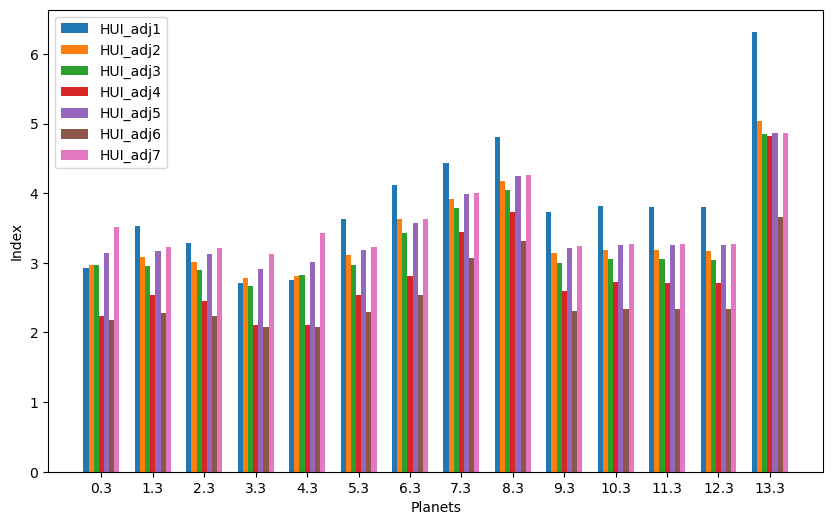

In [47]:
# pip install matplotlib
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

categories = HUI_data.columns[1:]  # ['Category1', 'Category2', ..., 'Category7']
bar_width = 0.1
index = np.arange(len(HUI_data))

for i, category in enumerate(categories):
    values = HUI_data[category]
    ax.bar(index + i * bar_width, values, bar_width, label=category)

# Set ticks and labels
ax.set_xticks(index + bar_width * (len(categories) - 1) / 2)
#ax.set_xticklabels(df['Metric'])  # Use metrics for x-axis labels

# Optional: Add legend, title, and labels
ax.legend()
ax.set_xlabel('Planets')
ax.set_ylabel('Index')

# Show the plot
plt.show()


In [48]:
#data.to_csv('C:/Users/21sko/Desktop/dissertation/data/results_3.csv', index=False)


AFTER CHECK-IN WITH JAVIER
- need to add albedo
- need to get rid of radiation
- need to rename HZ ?
- need to think about potentially adding carbon stability
- need to create a playground to work on interactions

In [49]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

ALBEDO

In [50]:
def rsun_to_m(Rsun):
    rsun_m = Rsun*6.98e8

    return(rsun_m)

data['star_radius_m'] = data.apply(lambda row: rsun_to_m(row['star_radius_rsun']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [51]:
import math


def calculate_albedo(temp_calculated_K, star_teff_K, star_radius_rsun, star_distance_pc):

        Rs_in_m = star_radius_rsun*6.957e8
        d_in_m = star_distance_pc * 3.086e16
        Teq = temp_calculated_K / ((1+0.3)**0.25)
    # Calculate the term inside the fourth power
        term = (temp_calculated_K / star_teff_K) * math.sqrt(Rs_in_m / (2*d_in_m))
        # print(term)
    # Calculate albedo
        albedo = 1 - term**4
        print(f"Teq = {Teq}, Tstar = {star_teff_K}, a = {d_in_m}, R = {Rs_in_m}, Albedo = {round(albedo, 2)}")
        return albedo
        

data['albedo'] = data.apply(lambda row: calculate_albedo(row['temp_calculated_K'], row['star_teff_K'], row['star_radius_rsun'], row['star_distance_pc']), axis = 1)
print(data)


Teq = 406.4469710609181, Tstar = 3406, a = 3.360654e+17, R = 269931600.0, Albedo = 1.0
Teq = 787.6080706503044, Tstar = 4870, a = 5.12276e+18, R = 498816900.0, Albedo = 1.0
Teq = 1336.4051329583642, Tstar = 5743, a = 1.379442e+19, R = 1063029600.0, Albedo = 1.0
Teq = 1732.5504526790287, Tstar = 11361, a = 1.543e+18, R = 1593153000.0, Albedo = 1.0
Teq = 422.88278751741376, Tstar = 2560, a = 3.73406e+17, R = 81396900.0, Albedo = 1.0
Teq = 3178.527695347364, Tstar = 7996, a = 3.05514e+18, R = 1620981000.0, Albedo = 1.0
Teq = 412.0660536101474, Tstar = 5778, a = 58325400000.0, R = 695700000.0, Albedo = 1.0
Teq = 690.2106397969968, Tstar = 5778, a = 107701400000.0, R = 695700000.0, Albedo = 1.0
Teq = 196.66788922302487, Tstar = 5778, a = 227438200000.0, R = 695700000.0, Albedo = 1.0
Teq = 154.52477010380525, Tstar = 5778, a = 777672000000.0, R = 695700000.0, Albedo = 1.0
Teq = 125.49284359945398, Tstar = 5778, a = 1431904000000.0, R = 695700000.0, Albedo = 1.0
Teq = 71.17504562357091, Tstar

In [52]:
def albedo(temp_calculated_K, star_teff_K, star_radius_m, star_distance_m):
    top = temp_calculated_K
    bottom = star_teff_K * math.sqrt((star_radius_m/(2*star_distance_m)))
    albedo = 1 - ((top/bottom)**4)

    return albedo

data['albedo'] = data.apply(lambda row: albedo(row['temp_calculated_K'], row['star_teff_K'], row['star_radius_m'], row['star_distance_m']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [53]:
data['Luminosity_W'] = data['Luminosity_Lsun'] * 3.828e26  


In [54]:
print(data['Luminosity_W'])
print(data['star_distance_m'])
print(data['temp_calculated_K'])

0     1.067820e+25
1     1.493959e+26
2     6.925029e+26
3     1.558622e+28
4     4.306217e+22
5     3.764877e+27
6     3.828000e+26
7     3.828000e+26
8     3.828000e+26
9     3.828000e+26
10    3.828000e+26
11    3.828000e+26
12    3.828000e+26
13    3.828000e+26
Name: Luminosity_W, dtype: float64
0     3.360654e+17
1     5.122760e+18
2     1.379442e+19
3     1.543000e+18
4     3.734060e+17
5     3.055140e+18
6     5.832540e+10
7     1.077014e+11
8     2.274382e+11
9     7.776720e+11
10    1.431904e+12
11    2.567552e+12
12    4.496302e+12
13    1.496710e+11
Name: star_distance_m, dtype: float64
0      434.00
1      841.00
2     1427.00
3     1850.00
4      451.55
5     3394.00
6      440.00
7      737.00
8      210.00
9      165.00
10     134.00
11      76.00
12      72.00
13     288.00
Name: temp_calculated_K, dtype: float64


In [55]:
print(data['planet'])

0     COCONUTS-2 b
1       HAT-P-18 b
2       HAT-P-42 b
3      kappa And b
4     TRAPPIST-1 b
5       WASP-189 b
6          Mercury
7            Venus
8             Mars
9          Jupiter
10          Saturn
11          Uranus
12         Neptune
13           Earth
Name: planet, dtype: object


In [56]:
import scipy.optimize as opt
import numpy as np

# Constants
sigma = 5.670374419e-8  # Stefan-Boltzmann constant, W/m^2/K^4

def equations(vars, L_star, d):
    Teq, A_B = vars
    # Equation for Teq without considering the greenhouse effect
    eq1 = Teq**4 - (L_star * (1 - A_B) / (16 * np.pi * sigma * d**2))
    
    # Equation for Bond albedo in terms of Teq
    eq2 = A_B - (1 - (16 * np.pi * sigma * d**2 * Teq**4 / L_star))
    
    return [eq1, eq2]



L_star = 1.067820e+25
d =  3.360654e+17

# Initial guess for Teq and A_B
initial_guess = [404, 0.3]  # Initial guesses for Teq and A_B

# Solve the system of equations
solution = opt.fsolve(equations, initial_guess, args=(L_star, d))

Teq, A_B = solution

print(f"Solved Equilibrium Temperature (Teq): {Teq:.2f} K")
print(f"Solved Bond Albedo (A_B): {A_B:.2f}")


Solved Equilibrium Temperature (Teq): 403.12 K
Solved Bond Albedo (A_B): -796099396713144.88


CARBON 12

In [57]:
'''
#column_name = 'temp_calculated_K'
threshold = 3915

def C_state(temperature):
    if temperature <= threshold:
        return 1
    else:
        return 2
    
data['12C_state'] = data['temp_calculated_K']. apply(lambda x: C_state(x))
print(data)

'''

"\n#column_name = 'temp_calculated_K'\nthreshold = 3915\n\ndef C_state(temperature):\n    if temperature <= threshold:\n        return 1\n    else:\n        return 2\n    \ndata['12C_state'] = data['temp_calculated_K']. apply(lambda x: C_state(x))\nprint(data)\n\n"

In [58]:
# carbon is stable for bonding between 200 and 500 K
# and at stellar radiastion 0.8 or above

SOMETHING IS WRONG HERE - HOW IS MERCURY BETTER THAN MARS???????????

In [59]:
def C_stability_temp(temperature, mid_ideal = 288, min_nonideal = 200, max_nonideal = 500, d=1):

    def map_value(value, from_min, from_max, to_min, to_max):
        """
        Maps a value from one range to another.

        Parameters:
        value (float): The value to be mapped.
        from_min (float): The minimum of the original range.
        from_max (float): The maximum of the original range.
        to_min (float): The minimum of the target range.
        to_max (float): The maximum of the target range.

        Returns:
        float: The value mapped to the target range.
        """
        # Calculate the proportion of the value within the original range
        proportion = (value - from_min) / (from_max - from_min)
        
        # Calculate the mapped value in the target range
        mapped_value = to_min + proportion * (to_max - to_min)
        
        return mapped_value

    # Calculate shifted max
    '''
    mid_ideal = 350
    min_nonideal = 200
    max_nonideal = 500 
    '''
    LB = 0
    UB = 5500

    # Case 0: temperature is ideal -> return 1
    if temperature == mid_ideal:
        return 1
    
    # Case 1: temperature is between ideal and max nonideal -> map temperature value from -1 to -0.1
    if mid_ideal < temperature < max_nonideal:
        index = 0 - map_value(temperature, mid_ideal, max_nonideal, -1, -0.1)
        return index
    
    # Case 2: temperature is between min nonideal and ideal -> map temperature value from 0.1 to 1
    if min_nonideal < temperature < mid_ideal:
        index = map_value(temperature, min_nonideal, mid_ideal, 0.1, 1)
        return index
    
    # Case 3: temperature is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < temperature < UB:
        decrement = map_value(temperature, max_nonideal, UB, 0, 0.1)
        index = 0.25 - decrement
        return index
    
    # Case 4: temperature is between LB and min nonideal -> by definition the temperature is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < temperature < min_nonideal:
        decrement = map_value(temperature, LB, min_nonideal, -0.1, 0)
        index = 0.25 + decrement
        return index

data['C_stability_temp'] =  data['temp_calculated_K'].apply(C_stability_temp) 

print(data)
                

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

12C - RADIATION PART

In [60]:
data['relative_r'] = data['radiation_I'] / 3.552342e-24
print(data['relative_r'])

0     5.532915e-15
1     3.331455e-16
2     2.129699e-16
3     3.831002e-13
4     1.807327e-17
5     2.360435e-14
6     6.585063e+00
7     1.931224e+00
8     4.330605e-01
9     3.704098e-02
10    1.092566e-02
11    3.398106e-03
12    1.108063e-03
13    1.000000e+00
Name: relative_r, dtype: float64


!!! FAILS TO WORK INDEX WISE

In [61]:

def C_stability_radiation(relative_r, mid_ideal = 1, min_nonideal = 0.8, max_nonideal = 5, d=1):
    # relative_r = radiation / (3.552342e-24) 
    # print(relative_r)

    d_max = max_nonideal - mid_ideal
    d_min = mid_ideal - min_nonideal

        # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if  min_nonideal < relative_r < mid_ideal:
        new_value = d * (mid_ideal - relative_r) / d_min
    elif max_nonideal > relative_r > mid_ideal:
        new_value = d * (relative_r - mid_ideal) / d_max
    elif relative_r < min_nonideal:
        new_value = (-d) * ((mid_ideal - relative_r) / (mid_ideal - 0))
    else:
        new_value = (-d) * ((relative_r - mid_ideal) / ((5*max_nonideal)- mid_ideal))
        '''
    elif relative_r > max_nonideal:
        new_value = (-d) * ((temperature - mid_ideal) / (max_nonideal- mid_ideal))
        
    else:
        # Map values between V_ideal and V_max to [0, d]
        new_value = 0
     '''
    if new_value < 0:
        return new_value
    elif new_value > 0:
        return 1 - new_value
    elif new_value == 0:
        return 1
    
    return new_value
    

    
data['C_stability_radiation'] =  data['relative_r'].apply(C_stability_radiation) 
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

12C stability index

In [62]:
def C12_stability(temp, radiation):
    stability = temp + radiation
    return stability

data['C12_stability'] = data.apply(lambda row: C12_stability(row['C_stability_temp'], row['C_stability_radiation']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

PLAYTIME w/ INTERACTIONS

                    water  map_temperature    map_HZ  map_star_age  \
water                 NaN         0.018542  0.025370      0.441339   
map_temperature  0.018542              NaN  0.178414      0.864060   
map_HZ           0.025370         0.178414       NaN      0.283117   
map_star_age     0.441339         0.864060  0.283117           NaN   
C12_stability    0.033348         0.000726  0.060343      0.282349   

                 C12_stability  
water                 0.033348  
map_temperature       0.000726  
map_HZ                0.060343  
map_star_age          0.282349  
C12_stability              NaN  


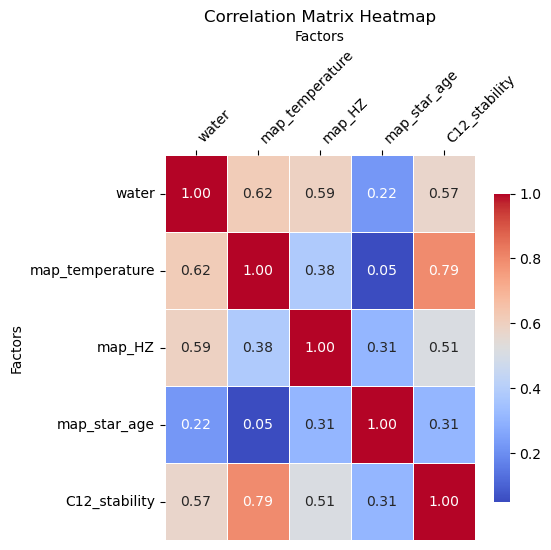

In [63]:
import numpy as np
import scipy.stats as stats
from scipy.special import betainc
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['water', 'map_temperature', 'map_HZ', 'map_star_age', 'C12_stability']
data_cor = data[selected_columns]

numeric_data_cor = data_cor.select_dtypes(include=[np.number])

correlation_matrix = numeric_data_cor.corr()

def calculate_p_value(r,n):
    df = n - 2
    t_squared = r**2 * (df/(1-r**2))
    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))
    return p_value


p_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)

for col1 in numeric_data_cor.columns:
    for col2 in numeric_data_cor.columns:
        if col1 != col2:
            # Calculate Pearson correlation
            r = correlation_matrix.loc[col1, col2]
            # Number of observations
            n = numeric_data_cor.shape[0]
            # Calculate p-value
            p_val = calculate_p_value(r, n)
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # or 1, since a variable is perfectly correlated with itself


print(p_values)
plt.figure(figsize=(5, 5))  # Set the size of the plot
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xticks(rotation=45, ha='left') 

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Factors')
plt.ylabel('Factors')

# Display the plot
plt.show()

In [64]:
results_lm = data[['water', 'map_HZ', 'C12_stability', 'map_temperature', 'map_star_age']]

print(results_lm)
#results_lm.to_csv('C:/Users/21sko/Desktop/dissertation/data/results_lm.csv', index=False)

       water    map_HZ  C12_stability  map_temperature  map_star_age
0   0.365048  0.000000      -0.619811         0.210811      0.005923
1   0.385002  0.000000      -0.756820         0.000001      0.710316
2   0.440753  0.000000      -0.768540         0.000001      0.461559
3   0.348463  0.000000      -0.777000         0.000001      0.121560
4   0.464018  0.000000      -0.694316         0.115946      0.000753
5   0.338016  0.000000      -0.807880         0.000001      0.836095
6   0.087909  0.000000       0.122006         0.178378      0.919840
7   0.525140  0.211684       1.012454         0.000001      0.919840
8   0.586419  0.887236      -0.364667         0.000001      0.919840
9   0.366021  0.000000      -0.730459         0.000001      0.919840
10  0.535819  0.000000      -0.772074         0.000001      0.919840
11  0.518129  0.000000      -0.808602         0.000001      0.919840
12  0.509313  0.000000      -0.812892         0.000001      0.919840
13  0.945847  0.527526       2.000

In [65]:
# playground = 